<a href="https://colab.research.google.com/github/yosbel-penate/AppEFThreading/blob/master/T2V_LSTM_KalmanFilter_2021_Commentary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykalman mlflow

Importar las librerias necesarias.

*   Pandas: En Computación y Ciencia de datos, Pandas es una biblioteca de software escrita como extensión de NumPy para manipulación y análisis de datos para el lenguaje de programación Python. En particular, ofrece estructuras de datos y operaciones para manipular tablas numéricas y series temporales.
*   The sklearn. metrics module implements several loss, score, and utility functions to measure classification performance. Some metrics might require probability estimates of the positive class, confidence values, or binary decisions values.


*   TensorFlow es una biblioteca de código abierto para aprendizaje automático a través de un rango de tareas, y desarrollado por Google para satisfacer sus necesidades de sistemas capaces de construir y entrenar redes neuronales para detectar y descifrar patrones y correlaciones, análogos al aprendizaje y razonamiento usados por los humanos.1​ 
*   MLflow es una plataforma de código abierto para administrar el ciclo de vida completo del aprendizaje automático. Proyectos: Permiten empaquetar el código de Machine Learning en una forma reutilizable y reproducible para compartirlo con otros científicos de datos o transferirlos a producción.
*  Pykalman Libreria en python que implementa el filtro Kalman.

In [ ]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error

from typing import Tuple, Dict

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import os

from mlflow import log_metric, log_param, log_artifacts

import warnings
warnings.filterwarnings("ignore")

from pykalman import KalmanFilter

En esta seccion que guardan los parametros del modelo y los datos que seran usados en MLFlow. CRIPTO es el nombre del par de la criptomoneda que se va a utilizar, VELAS es el periodo de actualizacion del con que ha sido construido el dataset. Con log_param() se van a crear los parametros de la libreria MLFlow. El diccionario 'param' almacena los parametros a utilizar en el modelo.

In [ ]:
CRIPTO = 'ADAEUR'
VELAS = '15m'
log_param("moneda", CRIPTO)
log_param("velas", VELAS)

SEQUENCE_LENGHT = 100

param = {
    'unit': 50,
    't2v_dim': 50,
    'lr': 1e-2, 
    'act': 'relu', 
    'epochs': 10,
    'batch_size': 100
}


Se monta la unidad de Driver don de esta guardado el Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Maestria 2 año 1 semestre/Инструментальные платформы прогнозной аналитики (Куляница Андрей Леонидович)/2021.csv')

In [ ]:
df.shape

In [ ]:
df.head()

,,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume ADA,Volume USDT,tradecount
1624492800000,2021-06-24 00:00:00,ADA/USDT,1.25130000,1.26300000,1.24570000,1.24850000,2515620.40000000,3155280.17353200,7054
1624406400000,2021-06-23 00:00:00,ADA/USDT,1.15630000,1.31000000,1.10800000,1.25120000,490479573.30000000,607806302.67524400,776745
1624320000000,2021-06-22 00:00:00,ADA/USDT,1.17380000,1.26340000,1.00010000,1.15670000,907361654.28000000,1030804095.18176200,1461174
1624233600000,2021-06-21 00:00:00,ADA/USDT,1.42620000,1.43710000,1.16720000,1.17400000,512064782.95000000,661793161.74010400,982646


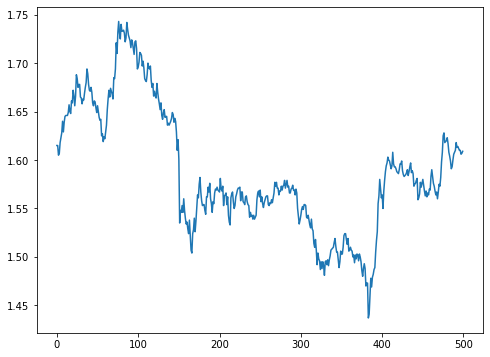

In [ ]:
df['close'].plot(figsize=(8,6))

In [ ]:

def KalmanTransform(df: pd.DataFrame,variable: str = 'close') -> None:
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean =df['{}'.format(variable)].values.mean(),
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.05)
    state_means, _ = kf.filter(df[variable].values)
    df['kalman'] = pd.Series(state_means.flatten(), index=df.index)

In [ ]:
df_tmp=df.copy()

kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean =df_tmp['close'].values.mean(),
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.05)
state_means, _ = kf.filter(df_tmp['close'].values)
df_tmp['kalman'] = pd.Series(state_means.flatten(), index=df.index)

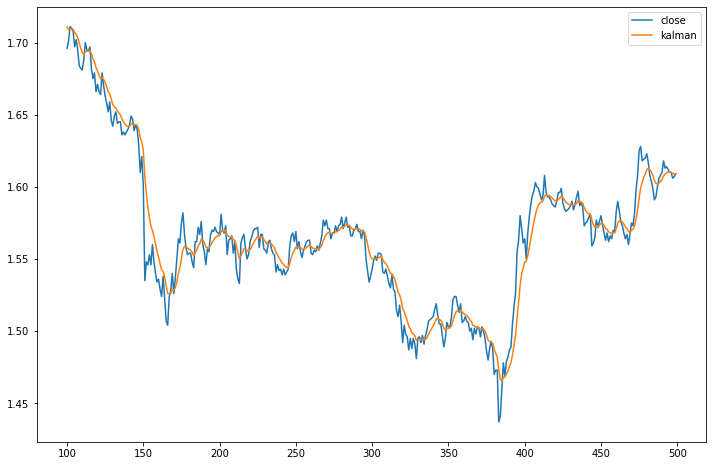

In [ ]:
df_tmp[['close','kalman']][100:1000].plot(figsize=(12,8))

https://www.cienciadedatos.net/images/transform_timeseries.gif

In [ ]:

def gen_sequence(id_df: pd.DataFrame, seq_length: int, seq_cols: str):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        


def gen_labels(id_df: pd.DataFrame, seq_length: int, label: str):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]


Paper: https://arxiv.org/pdf/1907.05321.pdf




In [ ]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)


### CREATE GENERATOR FOR LSTM AND T2V ###


def T2V_NN(param: Dict, dim: int = SEQUENCE_LENGHT):
    for key in param:
        log_param(key, param[key])
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m




In [ ]:

### PREPARE DATA TO FEED MODELS ###
def PrepareData(df: pd.DataFrame, KALMAN: bool = False, predict_variable: str = 'close', sequence_length: int = SEQUENCE_LENGHT)-> Tuple:
    X, Y = [], []
    log_param("kalman", KALMAN)
    log_param('sequence_length',sequence_length)
    if KALMAN:
        KalmanTransform(df, predict_variable)
        for sequence in gen_sequence(df, sequence_length, ['kalman']):
            X.append(sequence)
    else:
        for sequence in gen_sequence(df, sequence_length, [predict_variable]):
            X.append(sequence)

    for sequence in gen_labels(df, sequence_length, [predict_variable]):
        Y.append(sequence)

    X = np.asarray(X)
    Y = np.asarray(Y)



    ### TRAIN TEST SPLIT ###

    train_dim = int(0.7*len(df))
    X_train, X_test = X[:train_dim], X[train_dim:]
    y_train, y_test = Y[:train_dim], Y[train_dim:]

    print('Train shape X: '+str(X_train.shape)+' y: '+str(y_train.shape))
    print('Test shape X: '+str(X_test.shape)+' y: '+str(y_test.shape))
    return (X_train,X_test,y_train,y_test)


In [ ]:


### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###



m=T2V_NN(param)
print(m.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 t2v (T2V)                   (None, 100, 51)           5250      
                                                                 
 lstm (LSTM)                 (None, 50)                20400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 25,701
Trainable params: 25,701
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_train,X_test,y_train,y_test=PrepareData(df,KALMAN=False)

Train shape X: (350, 100, 1) y: (350, 1)
Test shape X: (50, 100, 1) y: (50, 1)


In [ ]:
m.fit(X_train,y_train, batch_size=param['batch_size'],epochs=param['epochs'])

Epoch 1/10
4/4 [==============================] - 2s 80ms/step - loss: 1.4297
Epoch 2/10
4/4 [==============================] - 0s 85ms/step - loss: 1.2615
Epoch 3/10
4/4 [==============================] - 0s 78ms/step - loss: 0.3402
Epoch 4/10
4/4 [==============================] - 0s 79ms/step - loss: 0.0132
Epoch 5/10
4/4 [==============================] - 0s 79ms/step - loss: 0.0063
Epoch 6/10
4/4 [==============================] - 0s 78ms/step - loss: 0.0105
Epoch 7/10
4/4 [==============================] - 0s 79ms/step - loss: 0.0057
Epoch 8/10
4/4 [==============================] - 0s 82ms/step - loss: 0.0029
Epoch 9/10
4/4 [==============================] - 0s 76ms/step - loss: 0.0041
Epoch 10/10
4/4 [==============================] - 0s 79ms/step - loss: 0.0023


In [ ]:
pred = m.predict(X_test).ravel()


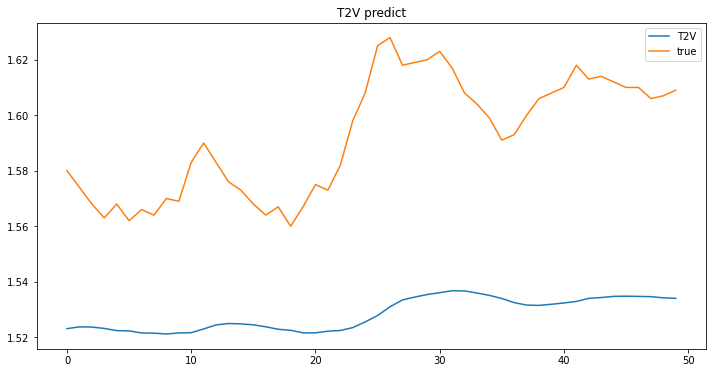

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(pred, label='T2V')
plt.plot(y_test.ravel(), label='true')
plt.title('T2V predict'); plt.legend()

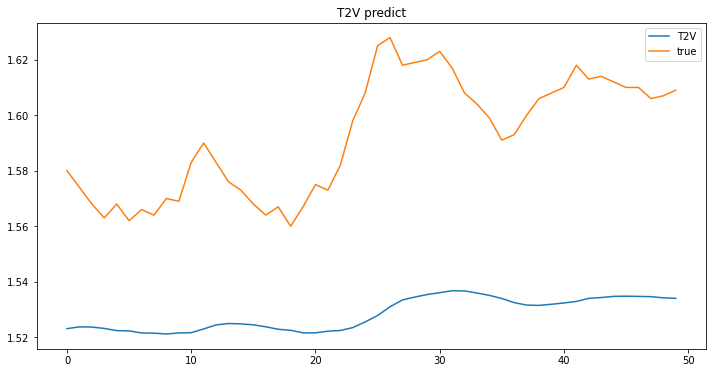

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(pred[:100], label='T2V')
plt.plot(y_test[:100].ravel(), label='true')
plt.title('T2V predict'); plt.legend()

In [ ]:
print(mean_absolute_error(y_test.ravel(), pred))
log_metric("MAE",mean_absolute_error(y_test.ravel(), pred)) 

0.06399768674850469


In [ ]:
!mlflow ui

[2021-12-04 10:32:54 +0000] [376] [INFO] Starting gunicorn 20.1.0
[2021-12-04 10:32:54 +0000] [376] [INFO] Listening at: http://127.0.0.1:5000 (376)
[2021-12-04 10:32:54 +0000] [376] [INFO] Using worker: sync
[2021-12-04 10:32:54 +0000] [379] [INFO] Booting worker with pid: 379
